<a href="https://colab.research.google.com/github/desireedisco/MSAI_Deep_Learning_LSTM/blob/main/week4_glove_lstm_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project overview and data description

**Task**: This is a binary classification problem and we need to classify a tweet as either 'Disaster' or not.

**Data**: There is 7600 tweets with classification labels as 1 (disaster) or 0 (not disaster). The training data has 5 columns (id, text, location, keyword, target).

**Process**: Clean and prepare the text, embed with glove embeddings, and train and predict using a LSTM model.

**Scored using F1**

In [ ]:
# install for glove embeddings
import sys
!{sys.executable} -m pip install staticvectors

In [ ]:
import os
import numpy as np
import pandas as pd
import itertools
import re
import html
import string

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from staticvectors import StaticVectors

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import Precision, Recall, F1Score
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
#import keras_nlp

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import RandomOverSampler

pd.set_option('future.no_silent_downcasting', True)

## Load and clean up data

In [ ]:
# load data
# when using kaggle
nlp_getting_started_path = '/kaggle/input/nlp-getting-started/'

train_df=pd.read_csv(os.path.join(nlp_getting_started_path, 'train.csv'))
test_df=pd.read_csv(os.path.join(nlp_getting_started_path, 'test.csv'))
submission_df=pd.read_csv(os.path.join(nlp_getting_started_path, 'sample_submission.csv'))

In [ ]:
# look at training data
print(train_df.shape)
print(train_df.head())

(7613, 5)
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [ ]:
# add label of disaster or not disaster
train_df['label'] = np.where(train_df['target'] == 1, 'Disaster', 'Not Disaster')

### Check for duplicates

In [ ]:
# fill NaNs in 'keyword' based on the non-NaN value within each group of (['text', 'target']) duplicates
train_df['location'] = train_df.groupby(['text', 'target'])['location'].transform(lambda x: x.fillna(x.dropna().iloc[0] if not x.dropna().empty else np.nan))

# fill NaNs in 'keyword' based on the non-NaN value within each group of (['text', 'target']) duplicates
train_df['keyword'] = train_df.groupby(['text', 'target'])['keyword'].transform(lambda x: x.fillna(x.dropna().iloc[0] if not x.dropna().empty else np.nan))

# drop duplicates where text and target are the same
train_df = train_df.drop_duplicates(subset=['text', 'target', 'keyword', 'location'])
train_df = train_df.drop_duplicates(subset=['text', 'target'], keep='last')
train_df.reset_index(drop=True, inplace=True)

In [ ]:
# check for duplicates where duplicate text has different labels
duplicates = train_df[train_df.duplicated(subset=['text'], keep=False)]
print(duplicates[['text','label']].sort_values(by='text'))

                                                   text         label
4240  #Allah describes piling up #wealth thinking it...  Not Disaster
4248  #Allah describes piling up #wealth thinking it...      Disaster
4188  #foodscare #offers2go #NestleIndia slips into ...  Not Disaster
4166  #foodscare #offers2go #NestleIndia slips into ...      Disaster
2799  .POTUS #StrategicPatience is a strategy for #G...  Not Disaster
2798  .POTUS #StrategicPatience is a strategy for #G...      Disaster
4530  CLEARED:incident with injury:I-495  inner loop...      Disaster
4550  CLEARED:incident with injury:I-495  inner loop...  Not Disaster
4180  Caution: breathing may be hazardous to your he...  Not Disaster
4177  Caution: breathing may be hazardous to your he...      Disaster
3202  He came to a land which was engulfed in tribal...  Not Disaster
3209  He came to a land which was engulfed in tribal...      Disaster
4244  Hellfire is surrounded by desires so be carefu...      Disaster
4229  Hellfire is su

In [ ]:
# delete all duplicates where duplicate text has different labels
train_df = train_df.drop_duplicates(subset=['text'], keep=False)
train_df.reset_index(drop=True, inplace=True)

## EDA

In [ ]:
# look at value counts of labels, keywords, and locations
print(train_df['label'].value_counts())
print(train_df['keyword'].value_counts())
print(train_df['location'].value_counts())

label
Not Disaster    4297
Disaster        3188
Name: count, dtype: int64
keyword
fatalities               45
deluge                   42
armageddon               42
damage                   41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64
location
USA                           104
New York                       71
United States                  50
London                         45
Canada                         29
                             ... 
SEA Server                      1
todaysbigstock.com              1
buenos aires argentina          1
everydaynigerian@gmail.com      1
Lincoln                         1
Name: count, Length: 3320, dtype: int64


### Is the dataset balanced?

**43% of tweets are labeled as disasters and 57% as non-disasters, therefore the dataset is fairly balanced. Even though we are scored by F1 which can be influenced by an imbalanced dataset, focusing on PR-AUC did not result in a score gain so no further action is taken for the imbalanced dataset**

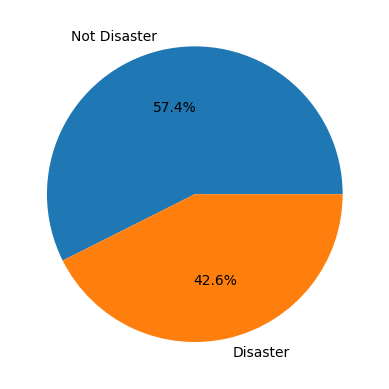

In [ ]:
x = train_df['label'].value_counts()
plt.pie(x.values,
        labels=x.index,
        autopct='%1.1f%%')
plt.show()

### Distribution of word count in tweets

In [ ]:
# look at text length in words
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))

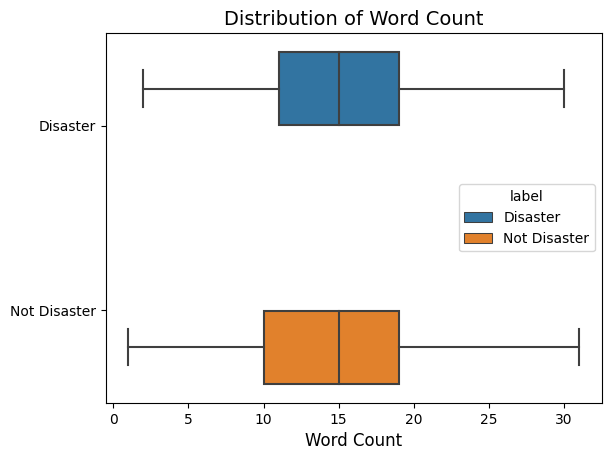

In [ ]:
# ploting the boxplot for word count distribution
sns.boxplot(data=train_df, x='text_length', y='label', hue='label')
plt.title('Distribution of Word Count', fontsize=14)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('')
plt.show()

### Preprocess data

In [ ]:
tweet_token = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

# swap the html pattern for <URL>
url_pat = re.compile(r'https?://\S+|www\.\S+')


# matches hashtags but captures just the word part
hashtag_pat = re.compile(r'#(\w+)')

def clean_tweet(text: str) -> str:
    if not isinstance(text, str):
        return ''

    # convert HTML entities within a string back into their corresponding characters
    text = html.unescape(text)

    # find and extract or remove HTML-like tags
    text = re.sub('<.*?>+', '', text)

    # replace url with <url>
    text = url_pat.sub(' <URL> ', text)

    #strip # from hashtag
    text = hashtag_pat.sub(r' \1 ', text)

    # describes a pattern that matches a sequence of characters containing at least one digit
    text = re.sub(r'\w*\d\w*', '', text)

    # remove ellipsis
    text = re.sub(r'\.{3}', ' ', text)

    # tokenize text
    tokens = tweet_token.tokenize(text)

    # remove stop words and join back to text string
    stop_words = stopwords.words('english')
    stop_words_removed = [word for word in tokens if word not in stop_words and len(word)>2]

    clean_text = ' '.join(stop_words_removed)

    return clean_text

In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
#clean train and text tweets and fillna
train_df['text'] = train_df['text'].fillna('')
test_df['text']  = test_df['text'].fillna('')
train_df['tweet_clean'] = train_df['text'].apply(clean_tweet)
test_df['tweet_clean']  = test_df['text'].apply(clean_tweet)

In [ ]:
train_df.head()

,id,keyword,location,text,target,label,text_length,tweet_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Disaster,13,deeds reason earthquake may allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Disaster,7,forest fire near ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,Disaster,22,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,Disaster,8,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Disaster,16,got sent photo ruby alaska smoke wildfires pou...


**Next I am going to preprocess the tweets by removing punctutation and stop words and use a tweet_tokenizer by nltk. I am also going to look at the words that are specific to each label by first grouping tweets by label and running through TF_IDF while setting max_df=.8**

In [ ]:
# convert text to TF-IDF
def top_tfidf_words(corpus):

    vectorizer = TfidfVectorizer(stop_words = 'english',
                              norm = 'l2',
                              encoding = 'latin-1',
                              ngram_range = (1,3),
                              max_df=.8)

    labels = train_df['label'].unique()
    doc_by_label = []

    # group into disaster and not disaster to see the difference in vocab for each label
    for label in labels:
        label_df = train_df[train_df['label'] == label]
        doc_by_label.append(' '.join(list(label_df[corpus])))


    tfidf_matrix = vectorizer.fit_transform(doc_by_label)
    feature_names = vectorizer.get_feature_names_out()


    df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    df_tfidf['label_'] = list(labels)

    top_words_by_class = {}
    for class_label in df_tfidf['label_'].unique():
        class_df = df_tfidf[df_tfidf['label_'] == class_label]
        # Sum TF-IDF scores for each word in this class, excluding the 'label' column
        word_scores = class_df.drop('label_', axis=1).sum(axis=0)
        top_words_by_class[class_label] = word_scores

    return top_words_by_class

In [ ]:
# method to get top words - use Counter
def get_top_n_words(label, column, n=None):
    # list containing all the extracted tokens
    token_collection = [token for text in train_df.loc[train_df['label']==label, column] for token in text.split() if len(text) > 0]
    # get the top n words
    top_words = Counter(token_collection).most_common(n)
    words = []
    freq = []
    for word, count in top_words:
        words.append(word)
        freq.append(count)
    # the words and freq lists with the top words and their frequencies
    return np.array(words), np.array(freq)

**I then display top words by label using counter and also the TF-IDF by label analysis**

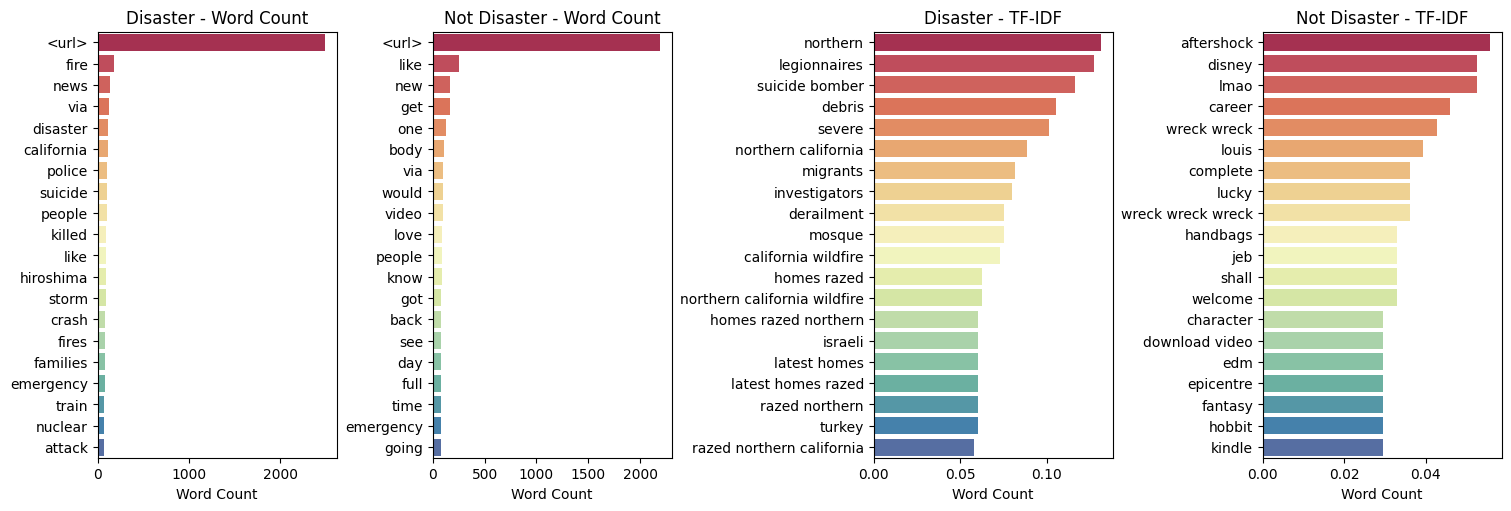

In [ ]:
tfidf_top_words_tweet = top_tfidf_words('tweet_clean')

# use barplots to show top words for title and text for each label
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(15, 5), constrained_layout=True)

N = 20 # Number of top words to retrieve

# I choose to show the top 20 words
words, freq = get_top_n_words('Disaster', 'tweet_clean', 20)
sns.barplot(x=freq, y=words, palette='Spectral', ax=ax1)
ax1.set_title('Disaster - Word Count')
ax1.set_xlabel('Word Count')
ax1.set_ylabel(None)

words, freq = get_top_n_words('Not Disaster', 'tweet_clean', 20)
sns.barplot(x=freq, y=words, palette='Spectral', ax=ax2)
ax2.set_title('Not Disaster - Word Count')
ax2.set_xlabel('Word Count')
ax2.set_ylabel(None)

dis_tweet_words = tfidf_top_words_tweet['Disaster'].nlargest(N)
sns.barplot(x=dis_tweet_words.values, y=dis_tweet_words.index, palette='Spectral', ax=ax3)
ax3.set_title('Disaster - TF-IDF')
ax3.set_xlabel('Word Count')
ax3.set_ylabel(None)

no_dis_tweet_words = tfidf_top_words_tweet['Not Disaster'].nlargest(N)
sns.barplot(x=no_dis_tweet_words.values, y=no_dis_tweet_words.index, palette='Spectral', ax=ax4)
ax4.set_title('Not Disaster - TF-IDF')
ax4.set_xlabel('Word Count')
ax4.set_ylabel(None)

plt.show()

**The first 2 graphs above on the left look at the top words by count and the above graphs on the right look at the top words that are unique to the label and focus on the less common words but common for the label.**

In [ ]:
# then I check a couple of keywords - keywords don't add value so no further work
#print(train_df[train_df['keyword'] == 'fatalities'])

**The keywords don't provide that much more information than just the tweet text so I am just going to use the tweet text as input to our model. Since I am not under or over sampling and I have preprocessed the tweets, I am ready to build and train the model.**

## Build and train model

### Step 1: Add glove embeddings

In [ ]:
# prep for glove embeddings by getting vocab of train_df tweets
train_text = train_df.tweet_clean.values

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_text)
vocab_length = len(word_tokenizer.word_index) + 1
print(vocab_length)

13798


In [ ]:
# load glove model
glove_model = StaticVectors("neuml/glove-2024-dolma")

In [ ]:
embedding_dim = 300 # match dim with glove file

embedding_matrix = np.zeros((vocab_length, embedding_dim))

value_error = []

#match glove embeddings to word in vocab of train_df tweets
for word, index in word_tokenizer.word_index.items():
    # get embedding vector for the word
    try:
      embedding_vector = glove_model.embeddings([word])[0]
      embedding_matrix[index] = embedding_vector

    except ValueError:
        value_error.append(word)
print(value_error)

['ûªve', 'ûïa', 'ûªre', 'ûªll', 'åêm', 'tìüp', 'ûïi', 'nno', 'wxky', "u'd", 'åêi']


In [ ]:
# get length of longest tweet by word count
longest_train_tweet = max(train_text, key=lambda sentence: len(word_tokenize(sentence)))
longest_train_len = len(word_tokenize(longest_train_tweet))
print(longest_train_tweet)
print(longest_train_len)

infantry mens lume dial army analog quartz wrist watch sport blue nylon fabric full rea <url> <url>
21


In [ ]:
# pad sequences to ensure that all tweet sequences have the same length
train_tweets = pad_sequences(word_tokenizer.texts_to_sequences(train_text), longest_train_len, padding='post')
test_tweets = pad_sequences(word_tokenizer.texts_to_sequences(test_df.tweet_clean.values), longest_train_len, padding='post')

### Step 2: Split dataset

In [ ]:
# stratified train/validation split
X = train_tweets
y = train_df['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=29, stratify=y, shuffle=True)

### Step 3: build the model

Basic LSTMs can only go in one direction and can only access past data. Bidirectional LSTMs can go both ways and can access past and future data. I think the biLSTM model will produce better results.

In [ ]:
def basic_LSTM():
    # basic LSTM model adapted from https://www.geeksforgeeks.org/deep-learning/long-short-term-memory-lstm-rnn-in-tensorflow/
    model = Sequential()
    model.add(layers.Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix]))
    model.add(layers.LSTM(longest_train_len, return_sequences=True))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(longest_train_len))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def bi_LSTM():
    # set up a sequential deep learning model
    model = Sequential()
    # embedding layer that converts tweet sequences into dense vectors
    model.add(layers.Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix]))
    model.add(layers.Bidirectional(layers.LSTM(longest_train_len, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(16)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = bi_LSTM()
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)

history = model.fit(
    X_train,
    y_train,
    epochs = 10,
    batch_size = 32,
    validation_data = [X_val, y_val],
    verbose = 1,
    callbacks = [reduce_lr, early_stopping_callback]
)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.6742 - loss: 0.5929 - val_accuracy: 0.8152 - val_loss: 0.4299 - learning_rate: 0.0010
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8585 - loss: 0.3562 - val_accuracy: 0.8013 - val_loss: 0.4463 - learning_rate: 0.0010
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9037 - loss: 0.2720 - val_accuracy: 0.8146 - val_loss: 0.4400 - learning_rate: 0.0010
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9264 - loss: 0.2185 - val_accuracy: 0.7890 - val_loss: 0.5103 - learning_rate: 0.0010
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9453 - loss: 0.1657 - val_accuracy: 0.7751 - val_loss: 0.5912 - learning_rate: 0.0010
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9630 - loss: 0.1172 - val_accuracy: 0.7911 - val_loss: 0.6540 - learning_rate: 0.0010
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1

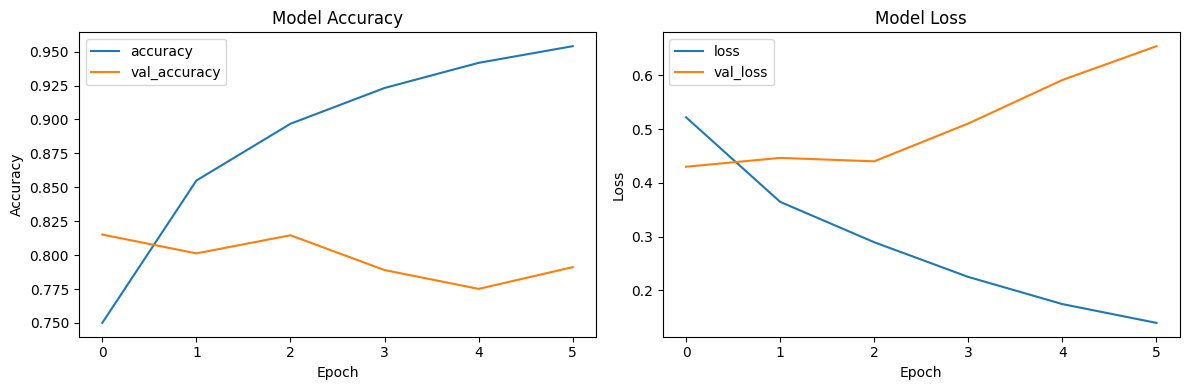

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Step 3: make prediction on test data and submit

In [ ]:
preds = (model.predict(X_val) > 0.5).astype("int32")
print("F1-score: ", f1_score(preds, y_val))

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
F1-score:  0.7470760233918129


In [ ]:
#bi-lstm: .80539
#basic-lstm: .80018

In [ ]:
# predict testing results
pred_prob = model.predict(test_tweets)
pred_prob = np.transpose(pred_prob)[0]
y_pred = list(map(lambda x: 0 if x < 0.5 else 1, pred_prob))

submission_df['target'] = y_pred
print(submission_df.head(20))
# when submitting to kaggle
submission_df.to_csv("submission.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
    id  target
0    0       0
1    2       1
2    3       1
3    9       0
4   11       1
5   12       0
6   21       0
7   22       0
8   27       0
9   29       0
10  30       0
11  35       0
12  42       0
13  43       0
14  45       0
15  46       0
16  47       0
17  51       1
18  58       0
19  60       0


## Conclusion

The biLSTM works the best.

https://www.geeksforgeeks.org/machine-learning/how-to-handle-imbalanced-classes-in-machine-learning/

https://towardsdatascience.com/text-classification-on-disaster-tweets-with-lstm-and-word-embedding-df35f039c1db/

https://www.geeksforgeeks.org/nlp/bidirectional-lstm-in-nlp/

https://keras.io/api/layers/recurrent_layers/lstm/

https://keras.io/api/layers/recurrent_layers/bidirectional/
